In [1]:
import cv2 as cv
import numpy as np
import random
import copy
from PIL import Image
from image_utils import *
from canvas import *
from scipy import ndimage
from sampling import Sampler
from config import parse_cfg
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
def display(img):
    return Image.fromarray(img)

In [15]:
a = cv.imread('objs/img0.jpg')

In [16]:
np.unique(a)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8, 247, 248, 249, 250,
       251, 252, 253, 254, 255], dtype=uint8)

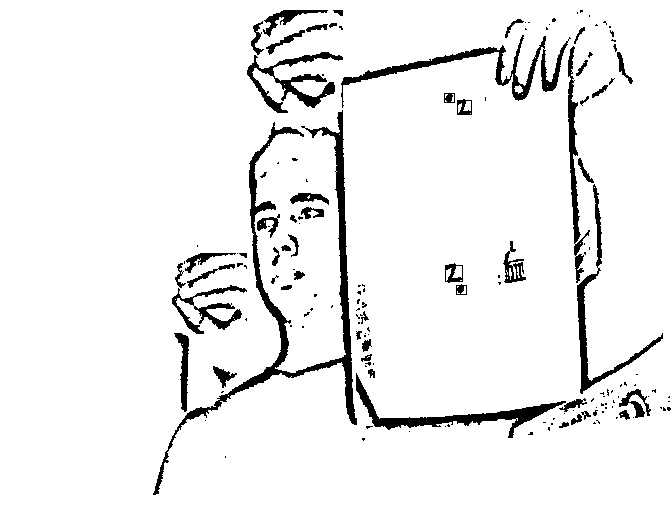

In [17]:
display(a)